In [70]:
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [4]:
PATH_TO_DATA_DIR = Path(os.getcwd()).resolve().parent.parent / "Data"

PATH_TO_CLEANED_DICOM_DF = PATH_TO_DATA_DIR / "cleaned_dicom_df.feather"

PATH_TO_SEGMENTATION_DF = PATH_TO_DATA_DIR / "segmentation_df.feather"
PATH_TO_BINCOUNT_HU_DF = PATH_TO_DATA_DIR / "bincount_HU_df.feather"
PATH_TO_BINCOUNT_STEP_75_DF = PATH_TO_DATA_DIR / "bincount_STEP_75_df.feather"
PATH_TO_BINCOUNT_STEP_150_DF = PATH_TO_DATA_DIR / "bincount_STEP_150_df.feather"
PATH_TO_TRAIN_TEST_SPLIT = PATH_TO_DATA_DIR / "train_test_split.feather"

In [3]:
cleaned_dicom_df = pd.read_feather(PATH_TO_CLEANED_DICOM_DF)
train_test_split_df = pd.read_feather(PATH_TO_TRAIN_TEST_SPLIT)

train_test_split_df = train_test_split_df[train_test_split_df["set_type"] == "Train"]

cleaned_dicom_df = pd.merge(cleaned_dicom_df, train_test_split_df, on="SeriesInstanceUID")
cleaned_dicom_df

,PatientId,PatientAge,PatientSex,PatientWeight,PatientSize,BodyPart,Rows,Columns,SliceCount,PixelSpacing,SliceThickness,RescaleSlope,RescaleIntercept,SeriesInstanceUID,SliceDirectory,set_type
0,ANONYM-3X1ZSG_1,61,F,46.0,1.61,Stamm,512,512,263,0.976562,3.0,1.0,-1024.0,1.2.40.0.13.1.28611523484845610500759615941748...,/srv/GadM/Datasets/AIBA_CT_KG/2021-02/10046CC6...,Train
1,ANONYM-3X1ZSG_2,59,M,107.0,1.72,Stamm,512,512,293,0.976562,3.0,1.0,-1024.0,1.2.40.0.13.1.29372383852567236771106277061240...,/srv/GadM/Datasets/AIBA_CT_KG/2021-02/10046DD0...,Train
2,ANONYM-3X1ZSG_5,40,M,103.0,1.80,Stamm,512,512,625,1.171875,3.0,1.0,-1024.0,1.2.40.0.13.1.79959759832434680761991964822026...,/srv/GadM/Datasets/AIBA_CT_KG/2021-02/10047228...,Train
3,ANONYM-3X1ZSG_10,79,M,73.0,1.77,Stamm,512,512,567,1.171875,3.0,1.0,-1024.0,1.2.40.0.13.1.24209483531338511718074425173759...,/srv/GadM/Datasets/AIBA_CT_KG/2021-02/10047CFF...,Train
4,ANONYM-3X1ZSG_11,77,M,125.0,1.84,Stamm,512,512,623,1.171875,3.0,1.0,-1024.0,1.2.40.0.13.1.33709088158668319679757985067945...,/srv/GadM/Datasets/AIBA_CT_KG/2021-02/10047F39...,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339,ANONYM-6LL37I_518,77,M,75.0,1.70,Stamm,512,512,567,1.171875,3.0,1.0,-1024.0,1.2.40.0.13.1.14447032145816928538722256306280...,/srv/GadM/Datasets/AIBA_CT_KG/2021-03/1006384E...,Train
2340,ANONYM-6LL37I_519,55,F,49.0,1.58,Stamm,512,512,567,1.171875,3.0,1.0,-1024.0,1.2.40.0.13.1.22055339428679588669178744381225...,/srv/GadM/Datasets/AIBA_CT_KG/2021-03/10063CCC...,Train
2341,ANONYM-6LL37I_520,51,F,63.0,1.74,Stamm,512,512,293,0.976562,3.0,1.0,-1024.0,1.2.40.0.13.1.15802889953337295246497758301352...,/srv/GadM/Datasets/AIBA_CT_KG/2021-03/10064142...,Train
2342,ANONYM-6LL37I_522,90,M,69.0,1.76,Stamm,512,512,567,1.171875,3.0,1.0,-1024.0,1.2.40.0.13.1.56298341537091980176000389528343...,/srv/GadM/Datasets/AIBA_CT_KG/2021-03/10064626...,Train


In [5]:
segmentation_df = pd.read_feather(PATH_TO_SEGMENTATION_DF)
bincount_HU_df = pd.read_feather(PATH_TO_BINCOUNT_HU_DF)
bincount_STEP_75_df = pd.read_feather(PATH_TO_BINCOUNT_STEP_75_DF)
bincount_STEP_150_df = pd.read_feather(PATH_TO_BINCOUNT_STEP_150_DF)

In [15]:
bincount_STEP_150_df

,0,150,300,450,600,750,900,1050,1200,1350,SeriesInstanceUID
0,150186951,15397009,2468436,1107430,867094,1139058,18883918,11349219,1053624,480060,1.2.40.0.13.1.31071640450076763248773322620109...
1,52469016,839092,284233,182347,167027,204623,3555502,3654841,377789,456157,1.2.40.0.13.1.28611523484845610500759615941748...
2,45197709,1115406,363675,192230,161841,423926,11652907,5548562,501668,342227,1.2.40.0.13.1.29372383852567236771106277061240...
3,54063419,1108301,386303,226131,204670,319554,10806618,4543915,439965,483228,1.2.40.0.13.1.18346535543421060503397480566267...
4,94269524,1117791,525117,321784,283396,371735,9940075,6793141,637750,642648,1.2.40.0.13.1.12817359503655381020457398908758...
...,...,...,...,...,...,...,...,...,...,...,...
5036,120319092,2773707,1179018,748897,388462,391749,4589405,7084749,333906,164016,1.2.40.0.13.1.22055339428679588669178744381225...
5037,56049001,974446,324573,197983,172779,197807,4972922,5382235,500240,501748,1.2.40.0.13.1.15802889953337295246497758301352...
5038,55585464,2824098,603400,448346,337270,306283,8883276,4565914,449230,346962,1.2.40.0.13.1.12285507575477120912134857019998...
5039,100096171,6307908,1415207,929437,520198,570492,9997582,6758312,607392,290138,1.2.40.0.13.1.56298341537091980176000389528343...


In [38]:
merged_segmentation_df = pd.merge(cleaned_dicom_df, segmentation_df, on="SeriesInstanceUID", how="left")
merged_segmentation_Air_df = pd.merge(merged_segmentation_df, bincount_HU_df[['Air', 'SeriesInstanceUID']], on="SeriesInstanceUID", how="left")
merged_segmentation_HU_df = pd.merge(merged_segmentation_df, bincount_HU_df, on="SeriesInstanceUID", how="left")
merged_segmentation_75_df = pd.merge(merged_segmentation_df, bincount_STEP_75_df, on="SeriesInstanceUID", how="left")
merged_segmentation_150_df = pd.merge(merged_segmentation_df, bincount_STEP_150_df, on="SeriesInstanceUID", how="left")

In [39]:
merged_segmentation_df.head()

,PatientId,PatientAge,PatientSex,PatientWeight,PatientSize,BodyPart,Rows,Columns,SliceCount,PixelSpacing,...,rib_right_5,rib_right_6,rib_right_7,rib_right_8,rib_right_9,rib_right_10,rib_right_11,rib_right_12,sternum,costal_cartilages
0,ANONYM-3X1ZSG_1,61,F,46.0,1.61,Stamm,512,512,263,0.976562,...,6616,7070,7570,6182,5634,4194,2742,1298,19364,42762
1,ANONYM-3X1ZSG_2,59,M,107.0,1.72,Stamm,512,512,293,0.976562,...,9286,8882,9522,8652,7602,6624,3806,1542,26048,57436
2,ANONYM-3X1ZSG_5,40,M,103.0,1.80,Stamm,512,512,625,1.171875,...,16339,16700,17584,14720,13000,9483,6600,3585,35267,99022
3,ANONYM-3X1ZSG_10,79,M,73.0,1.77,Stamm,512,512,567,1.171875,...,12916,15824,16716,14519,11015,8954,6647,3640,37120,105861
4,ANONYM-3X1ZSG_11,77,M,125.0,1.84,Stamm,512,512,623,1.171875,...,15216,17848,18780,14376,12728,12042,8656,4059,42704,93848


In [40]:
merged_segmentation_Air_df

,PatientId,PatientAge,PatientSex,PatientWeight,PatientSize,BodyPart,Rows,Columns,SliceCount,PixelSpacing,...,rib_right_6,rib_right_7,rib_right_8,rib_right_9,rib_right_10,rib_right_11,rib_right_12,sternum,costal_cartilages,Air
0,ANONYM-3X1ZSG_1,61,F,46.0,1.61,Stamm,512,512,263,0.976562,...,7070,7570,6182,5634,4194,2742,1298,19364,42762,46536326
1,ANONYM-3X1ZSG_2,59,M,107.0,1.72,Stamm,512,512,293,0.976562,...,8882,9522,8652,7602,6624,3806,1542,26048,57436,38774209
2,ANONYM-3X1ZSG_5,40,M,103.0,1.80,Stamm,512,512,625,1.171875,...,16700,17584,14720,13000,9483,6600,3585,35267,99022,78003136
3,ANONYM-3X1ZSG_10,79,M,73.0,1.77,Stamm,512,512,567,1.171875,...,15824,16716,14519,11015,8954,6647,3640,37120,105861,71707121
4,ANONYM-3X1ZSG_11,77,M,125.0,1.84,Stamm,512,512,623,1.171875,...,17848,18780,14376,12728,12042,8656,4059,42704,93848,60725727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339,ANONYM-6LL37I_518,77,M,75.0,1.70,Stamm,512,512,567,1.171875,...,13124,13772,14022,12060,9185,6338,4133,36320,90318,65074286
2340,ANONYM-6LL37I_519,55,F,49.0,1.58,Stamm,512,512,567,1.171875,...,10000,10000,8300,7560,5730,4050,1460,28636,65309,83609920
2341,ANONYM-6LL37I_520,51,F,63.0,1.74,Stamm,512,512,293,0.976562,...,6812,7524,6306,4960,4274,2658,714,20816,39476,49960160
2342,ANONYM-6LL37I_522,90,M,69.0,1.76,Stamm,512,512,567,1.171875,...,9552,11880,8568,9492,10206,5725,1553,38064,100457,68364056


In [41]:
merged_segmentation_HU_df

,PatientId,PatientAge,PatientSex,PatientWeight,PatientSize,BodyPart,Rows,Columns,SliceCount,PixelSpacing,...,Bone Cortical,Lung Parenchyma,Kidney,Liver,Lymph nodes,Muscle,Thymus (Children),Thymus (Adolescents),White matter,Grey matter
0,ANONYM-3X1ZSG_1,61,F,46.0,1.61,Stamm,512,512,263,0.976562,...,375405,278926,2173624,1326585,915460,2062969,1820525,4180326,1131634,1295282
1,ANONYM-3X1ZSG_2,59,M,107.0,1.72,Stamm,512,512,293,0.976562,...,537792,345860,3527092,1721158,2048264,2840256,3074768,6633570,2105339,1823933
2,ANONYM-3X1ZSG_5,40,M,103.0,1.80,Stamm,512,512,625,1.171875,...,556699,1541628,5474226,5961471,1592044,6978243,4175050,14773508,2204224,3842779
3,ANONYM-3X1ZSG_10,79,M,73.0,1.77,Stamm,512,512,567,1.171875,...,744304,1032802,4379945,2218171,2120429,3789554,3755211,7803960,2447463,2445554
4,ANONYM-3X1ZSG_11,77,M,125.0,1.84,Stamm,512,512,623,1.171875,...,512051,1969769,5841099,2340232,3437949,4463648,5138837,9541930,3555797,2962083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339,ANONYM-6LL37I_518,77,M,75.0,1.70,Stamm,512,512,567,1.171875,...,677496,1444194,5995956,3281844,2615459,5466410,5074237,10662980,3209523,3493502
2340,ANONYM-6LL37I_519,55,F,49.0,1.58,Stamm,512,512,567,1.171875,...,367744,1139413,4188226,2949025,1472028,4403294,3398417,7949724,1970981,2697685
2341,ANONYM-6LL37I_520,51,F,63.0,1.74,Stamm,512,512,293,0.976562,...,476402,315176,2984849,1999229,1185017,2943063,2477065,6071891,1512845,1819967
2342,ANONYM-6LL37I_522,90,M,69.0,1.76,Stamm,512,512,567,1.171875,...,444463,1380094,4582588,2355365,1964618,4167725,3872631,7885443,2425636,2697850


In [42]:
target = merged_segmentation_df['PatientWeight']

In [44]:
# Get all column names from bincount_STEP_150_df except column SeriesInstanceUID
voxel_columns_segmentation = segmentation_df.columns[0:-1].tolist()
voxel_columns_Air =  voxel_columns_segmentation + ['Air']
voxel_columns_HU =  voxel_columns_segmentation + bincount_HU_df.columns[0:-1].tolist()
voxel_columns_75 = voxel_columns_segmentation + bincount_STEP_75_df.columns[0:-1].tolist()
voxel_columns_150 = voxel_columns_segmentation + bincount_STEP_150_df.columns[0:-1].tolist()

print(voxel_columns_segmentation)
print(voxel_columns_Air)
print(voxel_columns_HU)
print(voxel_columns_75)
print(voxel_columns_150)

['spleen', 'kidney_right', 'kidney_left', 'gallbladder', 'liver', 'stomach', 'pancreas', 'adrenal_gland_right', 'adrenal_gland_left', 'lung_upper_lobe_left', 'lung_lower_lobe_left', 'lung_upper_lobe_right', 'lung_middle_lobe_right', 'lung_lower_lobe_right', 'esophagus', 'trachea', 'thyroid_gland', 'small_bowel', 'duodenum', 'colon', 'urinary_bladder', 'prostate', 'kidney_cyst_left', 'kidney_cyst_right', 'sacrum', 'vertebrae_S1', 'vertebrae_L5', 'vertebrae_L4', 'vertebrae_L3', 'vertebrae_L2', 'vertebrae_L1', 'vertebrae_T12', 'vertebrae_T11', 'vertebrae_T10', 'vertebrae_T9', 'vertebrae_T8', 'vertebrae_T7', 'vertebrae_T6', 'vertebrae_T5', 'vertebrae_T4', 'vertebrae_T3', 'vertebrae_T2', 'vertebrae_T1', 'vertebrae_C7', 'vertebrae_C6', 'vertebrae_C5', 'vertebrae_C4', 'vertebrae_C3', 'vertebrae_C2', 'vertebrae_C1', 'heart', 'aorta', 'pulmonary_vein', 'brachiocephalic_trunk', 'subclavian_artery_right', 'subclavian_artery_left', 'common_carotid_artery_right', 'common_carotid_artery_left', 'brac

In [53]:
merged_segmentation_df.loc[:, 'VoxelVolume'] = (merged_segmentation_df['PixelSpacing'] ** 2) * merged_segmentation_df['SliceThickness']
merged_segmentation_Air_df.loc[:, 'VoxelVolume'] = (merged_segmentation_Air_df['PixelSpacing'] ** 2) * merged_segmentation_Air_df['SliceThickness']
merged_segmentation_HU_df.loc[:, 'VoxelVolume'] = (merged_segmentation_HU_df['PixelSpacing'] ** 2) * merged_segmentation_HU_df['SliceThickness']
merged_segmentation_75_df.loc[:, 'VoxelVolume'] = (merged_segmentation_75_df['PixelSpacing'] ** 2) * merged_segmentation_75_df['SliceThickness']
merged_segmentation_150_df.loc[:, 'VoxelVolume'] = (merged_segmentation_150_df['PixelSpacing'] ** 2) * merged_segmentation_150_df['SliceThickness']


def apply_voxel_volume(row, voxel_columns):
    return row[voxel_columns] * row['VoxelVolume']

transformed_segmentation_df = merged_segmentation_df.copy()
transformed_segmentation_Air_df = merged_segmentation_Air_df.copy()
transformed_segmentation_HU_df = merged_segmentation_HU_df.copy()
transformed_segmentation_75_df = merged_segmentation_75_df.copy()
transformed_segmentation_150_df = merged_segmentation_150_df.copy()

transformed_segmentation_df[voxel_columns_segmentation] = merged_segmentation_df.apply(lambda row: apply_voxel_volume(row, voxel_columns_segmentation), axis=1)
transformed_segmentation_Air_df[voxel_columns_segmentation] = merged_segmentation_Air_df.apply(lambda row: apply_voxel_volume(row, voxel_columns_segmentation), axis=1)
transformed_segmentation_HU_df[voxel_columns_segmentation] = merged_segmentation_HU_df.apply(lambda row: apply_voxel_volume(row, voxel_columns_segmentation), axis=1)
transformed_segmentation_75_df[voxel_columns_segmentation] = merged_segmentation_75_df.apply(lambda row: apply_voxel_volume(row, voxel_columns_segmentation), axis=1)
transformed_segmentation_150_df[voxel_columns_segmentation] = merged_segmentation_150_df.apply(lambda row: apply_voxel_volume(row, voxel_columns_segmentation), axis=1)

In [55]:
transformed_segmentation_df['PatientSex_encoded'] =  transformed_segmentation_df['PatientSex'].map({'F': 0, 'M': 1}).copy()
transformed_segmentation_Air_df['PatientSex_encoded'] =  transformed_segmentation_Air_df['PatientSex'].map({'F': 0, 'M': 1}).copy()
transformed_segmentation_HU_df['PatientSex_encoded'] =  transformed_segmentation_HU_df['PatientSex'].map({'F': 0, 'M': 1}).copy()
transformed_segmentation_75_df['PatientSex_encoded'] =  transformed_segmentation_75_df['PatientSex'].map({'F': 0, 'M': 1}).copy()
transformed_segmentation_150_df['PatientSex_encoded'] =  transformed_segmentation_150_df['PatientSex'].map({'F': 0, 'M': 1}).copy()

In [56]:
base_columns_to_drop = ['PatientWeight', 'PatientId','Rows', 'Columns', 'RescaleSlope', 'RescaleIntercept', 'SeriesInstanceUID', 'SliceDirectory', 'BodyPart', 'PixelSpacing', 'SliceThickness', 'PatientSex', 'set_type'] # These columns wont be used in training

cleaned_segmentation_df = transformed_segmentation_df.drop(columns=base_columns_to_drop)
cleaned_segmentation_Air_df = transformed_segmentation_Air_df.drop(columns=base_columns_to_drop)
cleaned_segmentation_HU_df = transformed_segmentation_HU_df.drop(columns=base_columns_to_drop)
cleaned_segmentation_75_df = transformed_segmentation_75_df.drop(columns=base_columns_to_drop)
cleaned_segmentation_150_df = transformed_segmentation_150_df.drop(columns=base_columns_to_drop)

cleaned_segmentation_df

,PatientAge,PatientSize,SliceCount,spleen,kidney_right,kidney_left,gallbladder,liver,stomach,pancreas,...,rib_right_7,rib_right_8,rib_right_9,rib_right_10,rib_right_11,rib_right_12,sternum,costal_cartilages,VoxelVolume,PatientSex_encoded
0,61,1.61,263,6.109428e+04,86339.950562,118412.017822,0.000000,1.179073e+06,207412.719727,52968.978882,...,21657.943726,17686.843872,16119.003296,11999.130249,7844.924927,3713.607788,55400.848389,122343.063354,2.861023,0
1,59,1.72,293,1.224893e+06,227674.484253,266979.217529,1235.961914,3.402102e+06,686885.833740,113751.411438,...,27242.660522,24753.570557,21749.496460,18951.416016,10889.053345,4411.697388,74523.925781,164325.714111,2.861023,1
2,40,1.80,625,5.693829e+05,355479.125977,400900.726318,78607.177734,3.874551e+06,519960.937500,207320.251465,...,72443.847656,60644.531250,53558.349609,39068.756104,27191.162109,14769.744873,145295.562744,407958.068848,4.119873,1
3,79,1.77,567,3.199164e+05,207027.740479,211209.411621,40457.153320,2.473790e+06,802979.736328,103466.491699,...,68867.797852,59816.436768,45380.401611,36889.343262,27384.796143,14996.337891,152929.687500,436133.880615,4.119873,1
4,77,1.84,623,7.387056e+05,400468.139648,469566.650391,21682.891846,5.442760e+06,750179.443359,182798.767090,...,77371.215820,59227.294922,52437.744141,49611.511230,35661.621094,16722.564697,175935.058594,386641.845703,4.119873,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339,77,1.70,567,4.003116e+05,200423.583984,214579.467773,58996.582031,2.140014e+06,408011.627197,129607.086182,...,56738.891602,57768.859863,49685.668945,37841.033936,26111.755371,17027.435303,149633.789062,372098.693848,4.119873,1
2340,55,1.58,567,3.202954e+05,228150.329590,220475.006104,25048.828125,2.976555e+06,396517.181396,119422.760010,...,41198.730469,34194.946289,31146.240234,23606.872559,16685.485840,6015.014648,117976.684570,269064.788818,4.119873,0
2341,51,1.74,293,1.738586e+05,143491.744995,150981.903076,34049.034119,1.260999e+06,301351.547241,49146.652222,...,21526.336670,18041.610718,14190.673828,12228.012085,7604.598999,2042.770386,59555.053711,112941.741943,2.861023,0
2342,90,1.76,567,2.891656e+05,176487.121582,186939.239502,37309.570312,2.030405e+06,644302.825928,109844.055176,...,48944.091797,35299.072266,39105.834961,42047.424316,23586.273193,6398.162842,156818.847656,413870.086670,4.119873,1


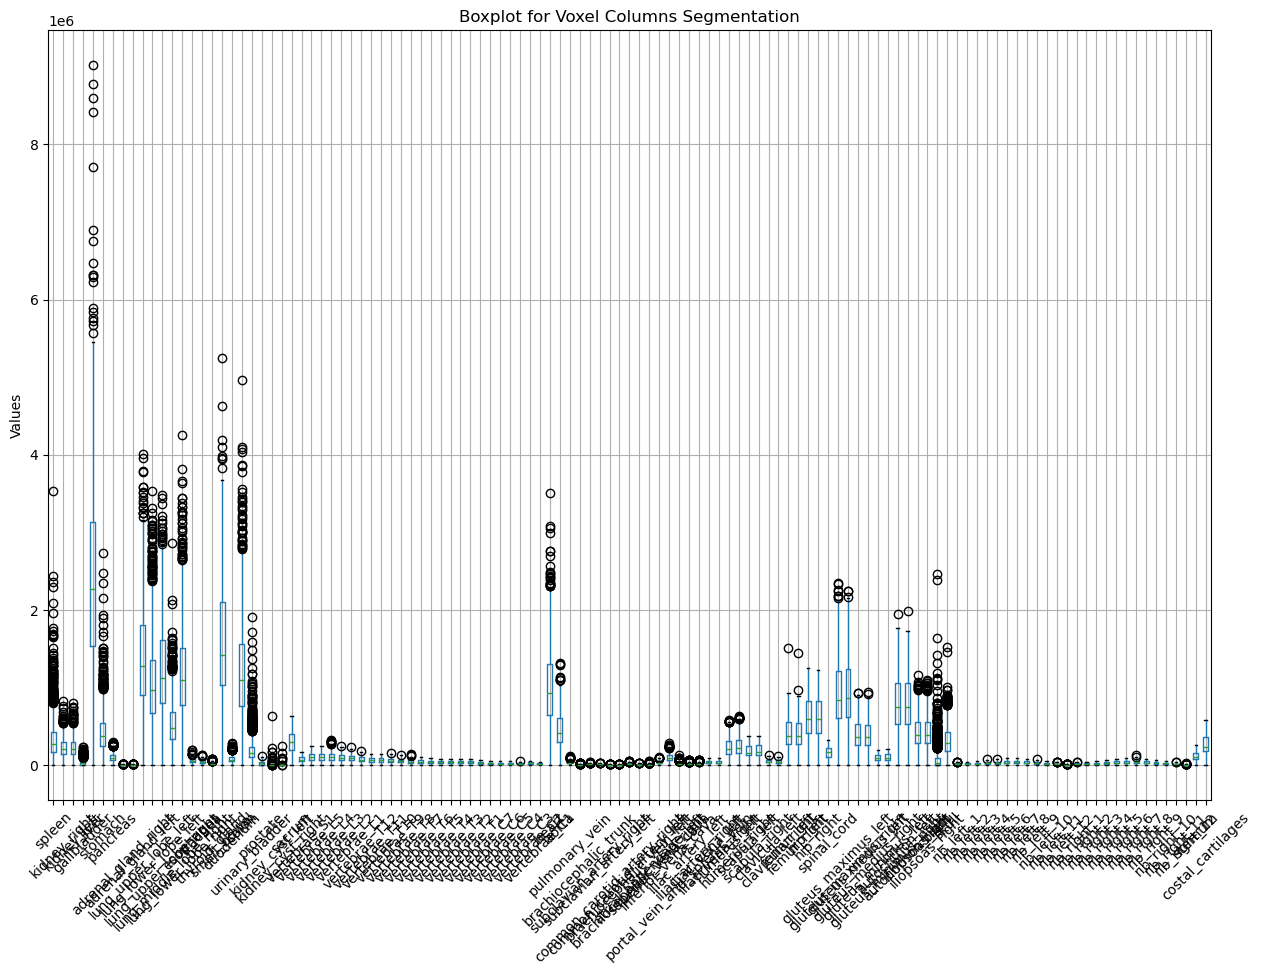

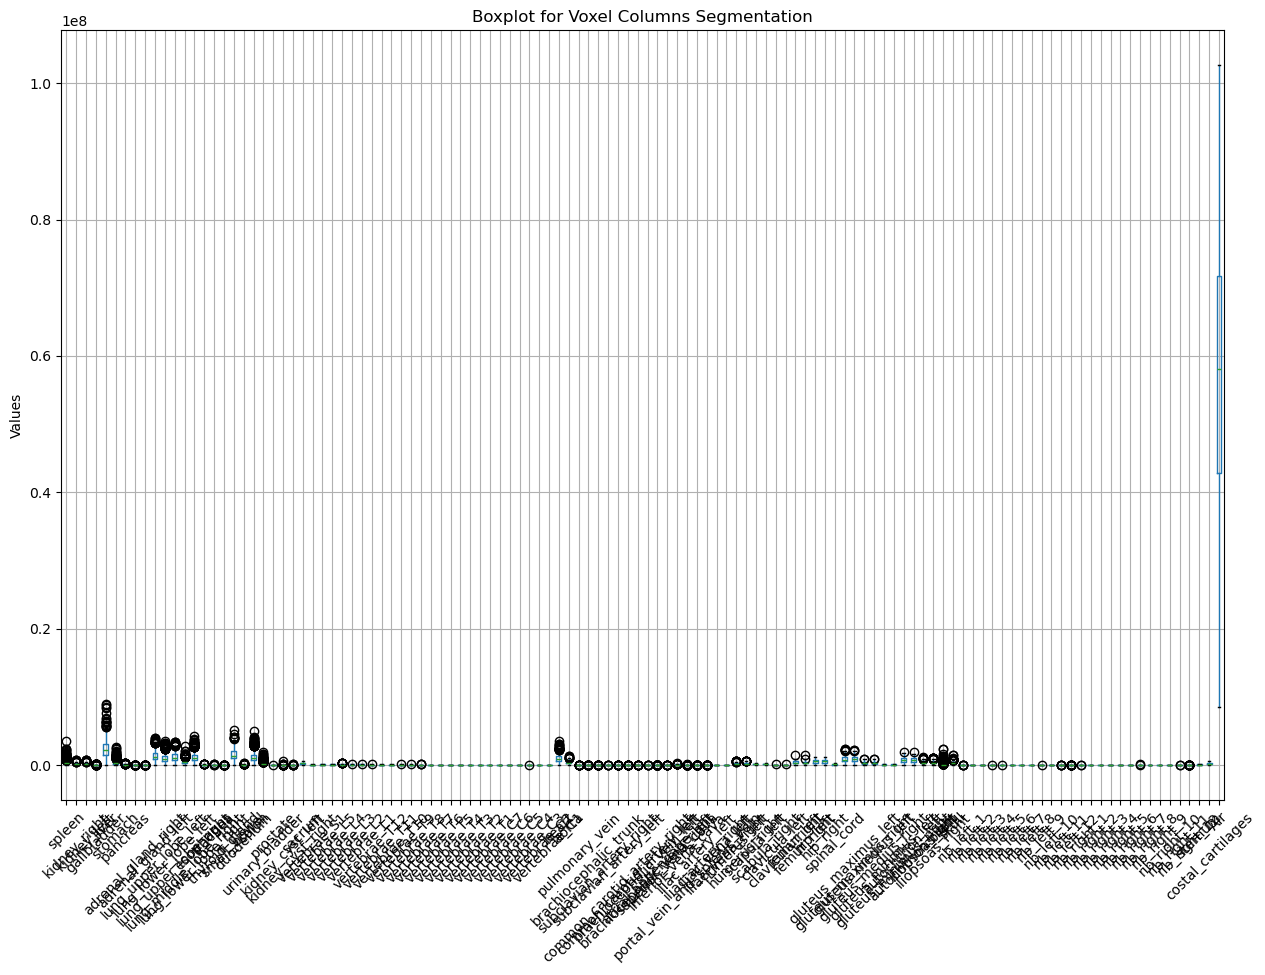

In [58]:
# Create a boxplot for the columns in voxel_columns_HU
cleaned_segmentation_df[voxel_columns_segmentation].boxplot(figsize=(15, 10))
plt.xticks(rotation=45)
plt.title('Boxplot for Voxel Columns Segmentation')
plt.ylabel('Values')
plt.show()

cleaned_segmentation_Air_df[voxel_columns_Air].boxplot(figsize=(15, 10))
plt.xticks(rotation=45)
plt.title('Boxplot for Voxel Columns Segmentation')
plt.ylabel('Values')
plt.show()

In [59]:
def find_best_model(X, y):
    param_grid = {
        'n_estimators': [50, 200],
        'max_depth': [3, 9],
        'min_samples_leaf': [1, 4]
    }

    gb = GradientBoostingRegressor()
    grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
    grid_search.fit(X, y)
    
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    return grid_search.best_estimator_

In [61]:
print('Finding best model for Segmentation')
best_model_seg = find_best_model(cleaned_segmentation_df, target)
print('Finding best model for Segmentation Air')
best_model_seg_air = find_best_model(cleaned_segmentation_Air_df, target)
print('Finding best model for Segmentation 75')
best_model_seg_75 = find_best_model(cleaned_segmentation_75_df, target)
print('Finding best model for Segmentation 150')
best_model_seg_150 = find_best_model(cleaned_segmentation_150_df, target)
print('Finding best model for Segmentation HU')
best_model_seg_HU = find_best_model(cleaned_segmentation_HU_df, target)

Finding best model for Segmentation
Fitting 5 folds for each of 8 candidates, totalling 40 fits
-5.7652328357387495
{'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 200}
Finding best model for Segmentation Air
Fitting 5 folds for each of 8 candidates, totalling 40 fits
-4.869932094225868
{'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}
Finding best model for Segmentation 75
Fitting 5 folds for each of 8 candidates, totalling 40 fits
-3.1434822416927233
{'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}
Finding best model for Segmentation 150
Fitting 5 folds for each of 8 candidates, totalling 40 fits
-3.1479607703510464
{'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}
Finding best model for Segmentation HU
Fitting 5 folds for each of 8 candidates, totalling 40 fits
-3.3350116875084437
{'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 200}


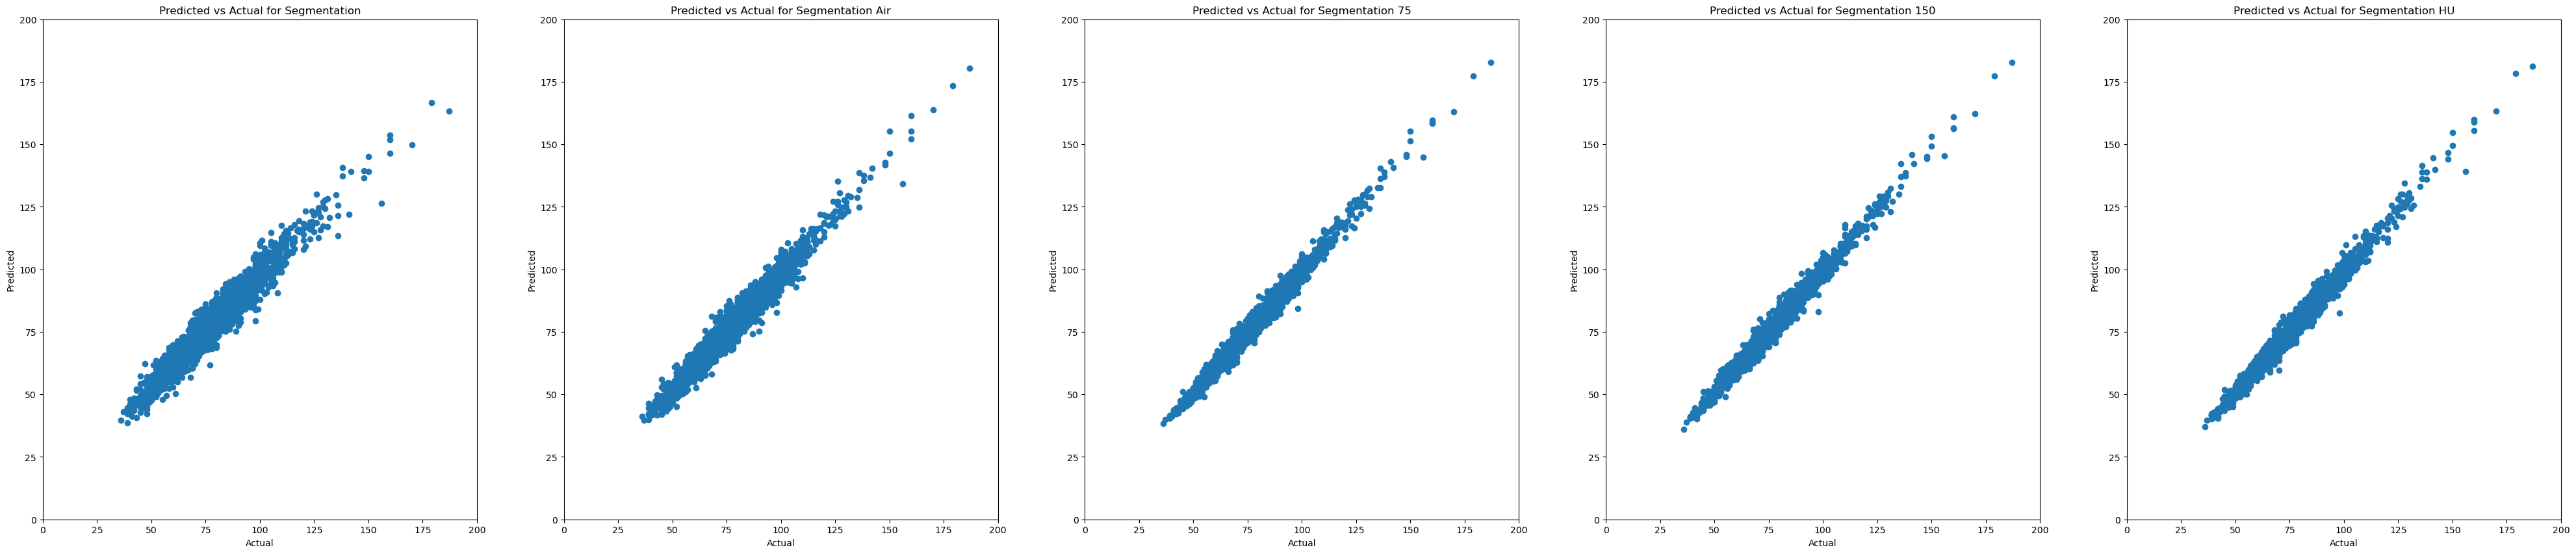

In [63]:
fig, axs = plt.subplots(1, 5, figsize=(50, 10))

axs[0].set_ylim([0, 200])
axs[1].set_ylim([0, 200])
axs[2].set_ylim([0, 200])
axs[3].set_ylim([0, 200])
axs[4].set_ylim([0, 200])

axs[0].set_xlim([0, 200])
axs[1].set_xlim([0, 200])
axs[2].set_xlim([0, 200])
axs[3].set_xlim([0, 200])
axs[4].set_xlim([0, 200])

axs[0].scatter(target, best_model_seg.predict(cleaned_segmentation_df))
axs[0].set_title('Predicted vs Actual for Segmentation')
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('Predicted')

axs[1].scatter(target, best_model_seg_air.predict(cleaned_segmentation_Air_df))
axs[1].set_title('Predicted vs Actual for Segmentation Air')
axs[1].set_xlabel('Actual')
axs[1].set_ylabel('Predicted')

axs[2].scatter(target, best_model_seg_75.predict(cleaned_segmentation_75_df))
axs[2].set_title('Predicted vs Actual for Segmentation 75')
axs[2].set_xlabel('Actual')
axs[2].set_ylabel('Predicted')

axs[3].scatter(target, best_model_seg_150.predict(cleaned_segmentation_150_df))
axs[3].set_title('Predicted vs Actual for Segmentation 150')
axs[3].set_xlabel('Actual')
axs[3].set_ylabel('Predicted')

axs[4].scatter(target, best_model_seg_HU.predict(cleaned_segmentation_HU_df))
axs[4].set_title('Predicted vs Actual for Segmentation HU')
axs[4].set_xlabel('Actual')
axs[4].set_ylabel('Predicted')

plt.show()

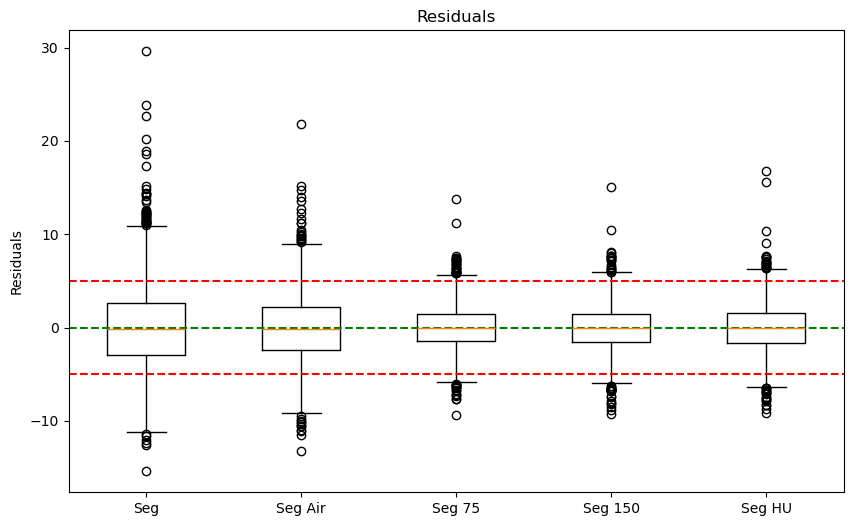

In [64]:
residuals_seg = target - best_model_seg.predict(cleaned_segmentation_df)
residuals_seg_air = target - best_model_seg_air.predict(cleaned_segmentation_Air_df)
residuals_seg_75 = target - best_model_seg_75.predict(cleaned_segmentation_75_df)
residuals_seg_150 = target - best_model_seg_150.predict(cleaned_segmentation_150_df)
residuals_seg_HU = target - best_model_seg_HU.predict(cleaned_segmentation_HU_df)

plt.figure(figsize=(10, 6))
plt.boxplot([residuals_seg, residuals_seg_air, residuals_seg_75, residuals_seg_150, residuals_seg_HU], tick_labels=['Seg', 'Seg Air', 'Seg 75', 'Seg 150', 'Seg HU'])

plt.ylabel('Residuals')
plt.title('Residuals')

# Draw a horizontal line at 0 and 5
plt.axhline(y=0, color='g', linestyle='--')
plt.axhline(y=5, color='r', linestyle='--')
plt.axhline(y=-5, color='r', linestyle='--')

plt.show()

In [ ]:
def find_best_model_bayes(X, y):
    param_space = {
        'loss': Categorical(['squared_error', 'absolute_error']),
        'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
        'n_estimators': Integer(50, 500),
        'subsample': Real(0.5, 1.0, prior='uniform'),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 4),
        'min_weight_fraction_leaf': Real(0.0, 0.5, prior='uniform'),
        'max_depth': Integer(1, 9),
        'max_leaf_nodes': Integer(2, 10),
    }

    gb = GradientBoostingRegressor()
    bayes_search = BayesSearchCV(estimator=gb, search_spaces=param_space, n_iter=256, cv=8, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
    bayes_search.fit(X, y)
    
    print(bayes_search.best_params_)
    print(bayes_search.best_score_)
    return bayes_search.best_params_

In [69]:
print('Finding best model for Segmentation')
best_model_seg_bayes = find_best_model_bayes(cleaned_segmentation_df, target)

print('Finding best model for Segmentation Air')
best_model_seg_air_bayes = find_best_model_bayes(cleaned_segmentation_Air_df, target)

print('Finding best model for Segmentation 75')
best_model_seg_75_bayes = find_best_model_bayes(cleaned_segmentation_75_df, target)

print('Finding best model for Segmentation 150')
best_model_seg_150_bayes = find_best_model_bayes(cleaned_segmentation_150_df, target)

print('Finding best model for Segmentation HU')
best_model_seg_HU_bayes = find_best_model_bayes(cleaned_segmentation_HU_df, target)

Finding best model for Segmentation
Fitting 8 folds for each of 1 candidates, totalling 8 fits
OrderedDict([('learning_rate', 0.06301540103142515), ('loss', 'absolute_error'), ('max_depth', 3), ('max_leaf_nodes', 2), ('min_samples_leaf', 2), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.07764344583045753), ('n_estimators', 493), ('subsample', 0.837593432892257)])
-7.105128421047518
Finding best model for Segmentation Air
Fitting 8 folds for each of 1 candidates, totalling 8 fits
OrderedDict([('learning_rate', 0.11475516890658781), ('loss', 'absolute_error'), ('max_depth', 3), ('max_leaf_nodes', 8), ('min_samples_leaf', 3), ('min_samples_split', 3), ('min_weight_fraction_leaf', 0.31515930928464087), ('n_estimators', 335), ('subsample', 0.693484096495735)])
-6.990573724869298
Finding best model for Segmentation 75
Fitting 8 folds for each of 1 candidates, totalling 8 fits
OrderedDict([('learning_rate', 0.12229198022025305), ('loss', 'absolute_error'), ('max_depth', 6), ('max_l